In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import torch

from graph_utils import GraphData, load_graph, verify_graph, degrees, grid_extent

# Overlay Mesh Graph on UK Map

In [4]:
proj = ccrs.PlateCarree()

In [5]:
def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
      
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=proj)
        ax.text(lon + 0.1, lat + 0.1, city, transform=proj)
        
def bounding_box(ax, box):
    lon_min, lon_max, lat_min, lat_max = box
    top_left = [lon_min, lat_max]
    top_right = [lon_max, lat_max]
    bottom_left = [lon_min, lat_min]
    bottom_right = [lon_max, lat_min]
    
    corners = [
        bottom_left,
        top_left,
        top_right,
        bottom_right,
        bottom_left,
    ]
    
    lons, lats = zip(*corners)
    
    ax.plot(
        lons, lats,
        "r-", 
        transform=proj
    )
    
def grid_points(ax, grid_xy, color="green", markersize=1):
    ax.plot(grid_xy[0], grid_xy[1], 'o', color=color, transform=proj, markersize=markersize)

def mesh_points(ax, mesh_pos, mesh_node_levels=None, filter_level=None, color="g"):
    color_map = {
        0: 'blue',
        1: 'green',
        2: 'orange',
        3: 'cyan',
        4: 'magenta',
        5: 'yellow',
        6: 'black'
    }
    if mesh_node_levels:
        for i in range(len(mesh_pos[0])):
            if filter_level and mesh_node_levels[i] != filter_level:
                continue
            node_color = color_map[mesh_node_levels[i]]
            ax.plot(mesh_pos[0][i], mesh_pos[1][i], 'o', color=node_color, transform=proj, markersize=3)
    else:
        ax.plot(mesh_pos[0], mesh_pos[1], 'o', color=color, transform=proj, markersize=3)

def m2m_edges(ax, mesh_pos, m2m_edge_set, style="g-"):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            style, 
            transform=proj,
            linewidth=0.5
        )
        
def coarse2fine_edges(ax, coarse_pos, fine_pos, coarse2fine_edge_set):
    for edge in coarse2fine_edge_set:
        source = coarse_pos[:, edge[0]]
        target = fine_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set, mesh_node_levels=None, filter_mesh_level=None): 
    for edge in g2m_edge_set:
        if mesh_node_levels and filter_mesh_level and mesh_node_levels[edge[1]] != filter_mesh_level:
            continue
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=proj,
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=proj,
            linewidth=0.5
        )
        
def border_mask(ax, grid_xy, border_mask, marker_size=1):
    border_mask = border_mask.reshape(-1)
    for i, mask in enumerate(border_mask):
        if mask:
            pattern = 'bo'
        else:
            pattern = 'ro'
        ax.plot(grid_xy[0][i], grid_xy[1][i], pattern, transform=proj, markersize=marker_size)
    
def intersection(graph, coarse_graph):
    a = graph.mesh_pos.numpy().T
    b = coarse_graph.mesh_pos.numpy().T
    a = set([tuple(x) for x in a])
    b = set([tuple(x) for x in b])

    inters = np.array(list(a.intersection(b))).T
    return inters

## Verify Space Attention Graph

(2, 46, 40)
(2, 27, 27)
Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(1839)
Mesh nodes min, max:  tensor(0) tensor(78)
Grid Nodes unique: 1840
Mesh nodes unique: 79
Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(78)
Mesh nodes min, max:  tensor(0) tensor(1839)
Grid Nodes unique: 79
Mesh nodes unique: 1840
Grid Bounding box:
[-8.0, 1.75, 49.75, 61.0]
Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(728)
Mesh nodes min, max:  tensor(0) tensor(72)
Grid Nodes unique: 729
Mesh nodes unique: 73
Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(72)
Mesh nodes min, max:  tensor(0) tensor(728)
Grid Nodes unique: 73
Mesh nodes unique: 729
Grid Bounding box:
[-13.0, 6.5, 45.5, 65.0]


(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: >)

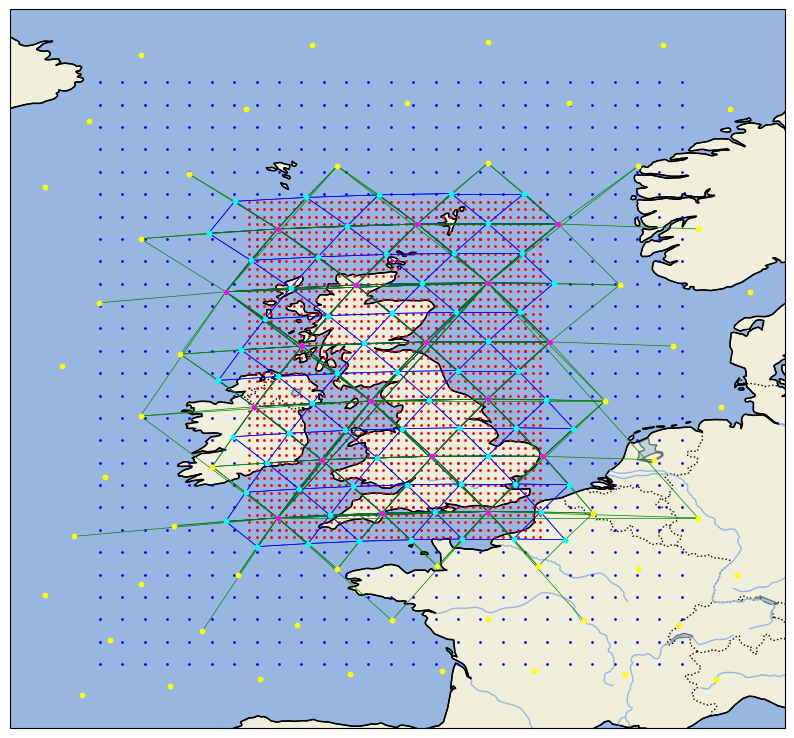

In [12]:
def verify_space_attention(
    dataset, graph_name, 
    dataset_coarse, coarse_graph_name,
    c2f_name,
):
    graph = load_graph(dataset, graph_name)
    coarse_graph = load_graph(dataset_coarse, coarse_graph_name)
    verify_graph(graph)
    verify_graph(coarse_graph)
    
    coarse2fine_edge_index = torch.load(f"./graphs/{graph_name}/{c2f_name}.pt")
    coarse2fine_edge_set = sorted(list({tuple(e) for e in coarse2fine_edge_index.T}))
    
    inter = intersection(graph, coarse_graph)
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
    add_geo_features(ax)

    grid_points(ax, coarse_graph.grid_xy, "blue")
    grid_points(ax, graph.grid_xy, "red")
    
    # g2m_edges(ax, graph.grid_xy, graph.mesh_pos, graph.g2m_edge_set)
    # g2m_edges(ax, coarse_graph.grid_xy, coarse_graph.mesh_pos, coarse_graph.g2m_edge_set)
    
    m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set, style="b-")
    # m2m_edges(ax, coarse_graph.mesh_pos, coarse_graph.m2m_edge_set)

    mesh_points(ax, graph.mesh_pos, color="cyan")
    mesh_points(ax, coarse_graph.mesh_pos, color="yellow")
    coarse2fine_edges(ax, coarse_graph.mesh_pos, graph.mesh_pos, coarse2fine_edge_set)
    
    mesh_points(ax, graph.mesh_pos, color="cyan")
    mesh_points(ax, coarse_graph.mesh_pos, color="yellow")
    mesh_points(ax, inter, color="magenta")
    
    return fig, ax


dataset = "era5_uk_small"
graph_name = "uk_small_ico"

# dataset = "era5_uk"
# graph_name = "uk_ico"

# dataset = "era5_uk_big"
# graph_name = "uk_big_ico"

# dataset = "era5_uk_max"
# graph_name = "uk_max_ico"

dataset_coarse = "era5_uk_big_coarse"
coarse_graph_name = "uk_big_coarse_ico"
c2f_name = "big_coarse2fine_edge_index"
# c2f_name = "big_coarse2fine_v2_edge_index"
# c2f_name = "big_coarse2fine_v3_edge_index"

# dataset_coarse = "era5_uk_max_coarse"
# coarse_graph_name = "uk_max_coarse_ico"

verify_space_attention(
    dataset, graph_name,
    dataset_coarse, coarse_graph_name,
    c2f_name,
)

## Verify Single Graph

(2, 65, 57)
Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(3704)
Mesh nodes min, max:  tensor(0) tensor(148)
Grid Nodes unique: 3705
Mesh nodes unique: 149
Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(148)
Mesh nodes min, max:  tensor(0) tensor(3704)
Grid Nodes unique: 149
Mesh nodes unique: 3705
Grid Bounding box:
[-10.0, 4.0, 47.0, 63.0]
Unmasked nodes 1865


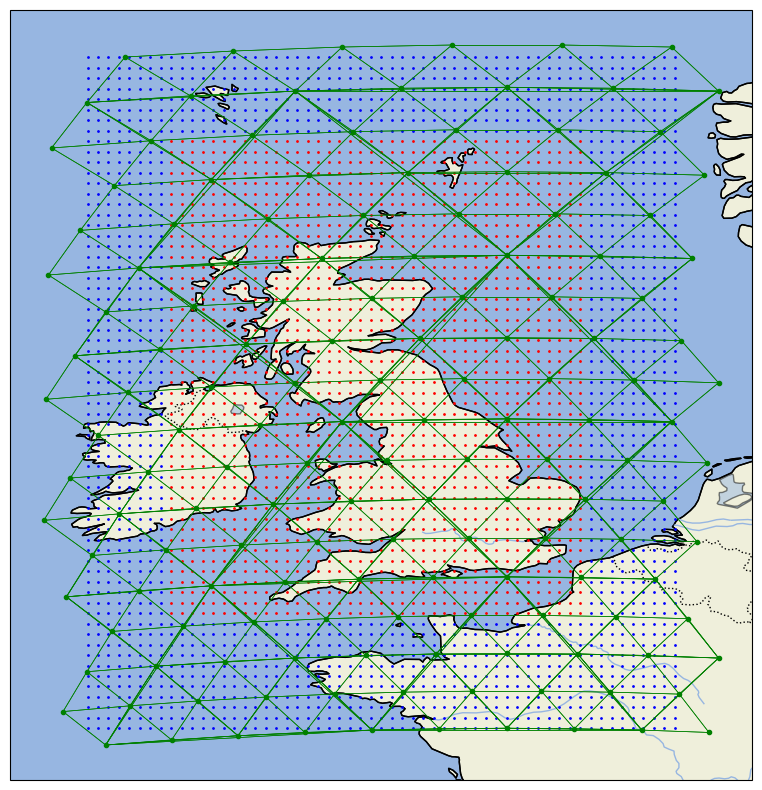

In [8]:
def verify_single_graph(dataset, graph_name):
    graph = load_graph(dataset, graph_name)
    verify_graph(graph)
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
    add_geo_features(ax)

    # no border mask for smallest dataset or coarse graphs
    if dataset == "era5_uk_small" or "coarse" in dataset:
        grid_points(ax, graph.grid_xy, "red")
    else:
        mask = np.load(f"data/{dataset}/static/border_mask.npy").astype(int)
        border_mask(ax, graph.grid_xy, mask)
        print("Unmasked nodes", mask.sum())
    
    # g2m_edges(ax, graph.grid_xy, graph.mesh_pos, graph.g2m_edge_set)
    # m2g_edges(ax, graph.grid_xy, graph.mesh_pos, graph.m2g_edge_set)
    m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set)
    mesh_points(ax, graph.mesh_pos)
    
    return fig, ax

dataset = "era5_uk"
graph_name = "uk_ico"
fig, ax = verify_single_graph(dataset, graph_name)